# Esto es: determinamos Gamma asumiendo gaussian priors para Alpha y Beta

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM, Planck13
from scipy import integrate as it

from multiprocessing import Pool
from functools import partial

cosmo = FlatLambdaCDM(H0=67.3, Om0=0.315)

In [2]:
# data (.txt) Tabla I: https://arxiv.org/abs/1509.07649
# Schwab: https://arxiv.org/pdf/0907.4992.pdf 

data = np.loadtxt('sample80.txt')
n_threads = 1# un thread es suficiente para el caso beta=constante

ns = 80 # numero de sistemas de lentes fuertes

zl = data[:ns,0] # redshift de la lente
zs = data[:ns,1] # redshift de la fuente
sigma_0 = data[:ns,7] # dispersion de velocidad
epsilon_0 = data[:ns,8] # incertidumbre en sigma_0
th_E_arcsec = data[:ns,4] # anillo de Einstein en arcsec
th_ap_arcsec = data[:ns,5] # theta_aperture en arcsec
seeing_arcsec = data[:ns,6] # atmospheric seeing

print(len(zl))

80


In [3]:
# Aca solo vienen algunas variables que utilizaremos mas adelante

delta = 2.4
eps_alpha = 0.08
alpha_0 = 2.
eps_beta = 0.13
beta_0 = 0.18

# Some constants
c = (const.c).to(u.km/u.second)
pi = np.pi
clight = c.value

# Angular diameter distance    
DS = cosmo.angular_diameter_distance(zs)
DLL = (cosmo.angular_diameter_distance(zl)).to(u.kpc)
DL = DLL.value
DLS = cosmo.angular_diameter_distance_z1z2(zl, zs)
DS_DLS = (DS/DLS).value

# Einstein ring (rad)
s_E = th_E_arcsec
theta_E = (s_E*pi/180./3600.) # en rad
theta_E_2 =((s_E*pi/180./3600.)**2.) # en rad
     
#-------------------------------------

# theta aperture
s_ap = th_ap_arcsec
th_ap = (s_ap*pi/180./3600.) # en rad

# seeing atm
s_seeing = seeing_arcsec
seeing_atm = (s_seeing*pi/180./3600.)#/DL # en rad

chi = th_ap/seeing_atm
print('chi = ',chi[0])
print('seeing_atm',seeing_atm[0])
tilde_sigma = seeing_atm*np.sqrt(1.+(chi**2.)/4.+(chi**4.)/40.)
tilde_sigma_2 = tilde_sigma*tilde_sigma

div_s_t_2 = tilde_sigma_2/theta_E_2

theta_E_22=theta_E_2*DL*DL
div_s_t_22 = tilde_sigma_2/(theta_E_22)

#----------------------------------

n = 1.#*len(sigma_0)
eps_sem = epsilon_0/np.sqrt(n) 
sigma_0_sem = sigma_0/np.sqrt(n)

s_epsilon_0 = epsilon_0
epsilon_0_22 = s_epsilon_0**2.

epsilon_0_2 = epsilon_0_22/np.sqrt(1.)

beta_min = 0.1
beta_max = 9.20
alpha_min = 0.1 
alpha_max = 9.2
gamma = np.arange(0.1,15.0,0.01)

eps_sem_1 =(eps_sem)
DS_DLS_1 = (DS_DLS)
sigma_0_sem_1 = (sigma_0_sem)

gamma12 = np.arange(0.,4.0,0.01)
gamma11 = 10.

DLL = (cosmo.angular_diameter_distance(zl)).to(u.kpc)
DL = DLL.value
R_E = DL*theta_E

chi =  0.5555555555555555
seeing_atm 8.726646259971648e-06


In [4]:
# esta parte del código no la utilizamos. Es solo para el caso donde el paramámetro de anisotropía beta
# no es constante

def I1(R,z,bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta):
    zeta = delta+alpha-2.
    r = np.sqrt(R**2+z**2)
    beta = (bbin*ra**2+bbout*r**2)/(ra**2+r**2)
    ret1 = 2.*R*np.exp(-R**2/2./(DL*DL)/tilde_sigma_2)*(1.-beta*R**2/r**2)*r**(-zeta)*(1.+ra**2/r**2)**(bbin-bbout) \
           * sp.special.hyp2f1(bbin-bbout, (zeta-2.*bbout)/2.,(zeta-2.*bbout+2.)/2.,-ra**2/r**2 )
    
    #ret2 = DL*R+z#/(1.+R)+DL/(zeta+z)
    return np.asarray(ret1)

def I1_1(z,R,bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta):
    zeta = delta+alpha-2.
    r = np.sqrt(R**2+z**2)
    beta = (bbin*ra**2+bbout*r**2)/(ra**2+r**2)
    ret1 = 2.*R*np.exp(-R**2/2./(DL*DL)/tilde_sigma_2)*(1.-beta*R**2/r**2)*r**(-zeta)*(1.+ra**2/r**2)**(bbin-bbout) \
           * sp.special.hyp2f1(bbin-bbout, (zeta-2.*bbout)/2.,(zeta-2.*bbout+2.)/2.,-ra**2/r**2 )
    
    #ret2 = DL*R+z#/(1.+R)+DL/(zeta+z)
    return np.asarray(ret1)
   
def I2(bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta):    
    eps = 0.005
    
    I11 = eps**2 *I1(eps/2.,eps/2,bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta)
    
    z_min = eps#-np.Infinity
    z_max = np.Infinity
    R_min = eps
    R_max = np.Infinity
    
    integ01, err11 = it.quad(I1, R_min, R_max,args=(eps/2.,bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta),\
                            epsabs=1.49e-1, epsrel=1.49e-1) 
    
    integ0_1, err1_1 = it.quad(I1_1, z_min, z_max,args=(eps/2.,bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta),\
                            epsabs=1.49e-1, epsrel=1.49e-1) 
    
    integ0, err1 = it.dblquad(I1, z_min, z_max,lambda R: R_min,lambda R: R_max,\
                            args=(bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta),\
                            epsabs=1.49e-1, epsrel=1.49e-1)
    return integ0 + eps * (integ01 + integ0_1) + I11 #, err



In [5]:
# esta parte del código no la utilizamos. Es solo para el caso donde el paramámetro de anisotropía beta
# no es constante

def act_sigma(alpha,bbout,gamma,delta,bbin,ra,DL,tilde_sigma_2,DS_DLS,theta_E,R_E):
    zeta = delta+alpha-2.
    f2 = np.vectorize(I2)
    I22 = f2(bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta)
    #I22 = I2(bbin,bbout,ra,DL,tilde_sigma_2,alpha,delta)
    ret2 = np.sqrt(np.abs( ( 2./(1.+gamma)*(clight**2)/4.*DS_DLS*theta_E )* 2.*R_E**(alpha-2)/np.sqrt(pi)/(zeta-2.*bbout) \
          / (sp.special.gamma((alpha-1.)/2.)/sp.special.gamma(alpha/2.)) /np.sqrt(pi)/(2.**( (1.-delta)/2.) ) \
          / (DL*DL*tilde_sigma_2)**( (3.-delta)/2. )/sp.special.gamma( (3.-delta)/2.  ) \
          / (sp.special.gamma((delta-1.)/2.)/sp.special.gamma(delta/2.))*I22 ) )
    return ret2

In [6]:
def vel(alpha, beta, gamma, delta, DS_DLS, theta_E, div_s_t_2):
    'Esto es la dispersión de velocidad como esta en el paper de Schwab'
    #alpha, beta, delta, gamma = theta
    zeta = delta+alpha-2.
    
    #res1 = np.sqrt( np.abs( 2./(1.+gamma)*(clight**2)/4.*DS_DLS*theta_E*2./np.sqrt(pi) \
     #          * (2.*div_s_t_2)**(1.-alpha/2.) /(zeta-2.*beta) \
      #         * sp.special.gamma((3.-zeta)/2.)/sp.special.gamma((3.-delta)/2.) \
       #        * ( sp.special.gamma((zeta-1.)/2.)/sp.special.gamma(zeta/2.)  \
        #       - beta * (sp.special.gamma((zeta+1.)/2.)/sp.special.gamma((zeta+2.)/2.) ) ) \
         #      /(sp.special.gamma((alpha-1.)/2.)/sp.special.gamma(alpha/2.)) \
          #     /(sp.special.gamma((delta-1.)/2.)/sp.special.gamma(delta/2.) )  ) )
    
    res1 = np.sqrt( np.abs( 2./(1.+gamma)*(clight**2)/4.*DS_DLS*theta_E*2./np.sqrt(pi) \
               * (2.*div_s_t_2)**(1.-alpha/2.) /(zeta-2.*beta) \
               * sp.special.gamma((3.-zeta)/2.)/sp.special.gamma((3.-delta)/2.) \
               * ( sp.special.gamma((zeta-1.)/2.)/sp.special.gamma(zeta/2.)  \
               - beta * (sp.special.gamma((zeta+1.)/2.)/sp.special.gamma((zeta+2.)/2.) ) ) \
               /(sp.special.gamma((alpha-1.)/2.)/sp.special.gamma(alpha/2.)) \
               /(sp.special.gamma((delta-1.)/2.)/sp.special.gamma(delta/2.) )  ) )
    
    return res1

 A fin de estimar gamma seguimos el tutorial del ``emcee`` (https://emcee.readthedocs.io/en/stable/tutorials/line/) 

## Maximum likelihood estimation

The least squares solution found in the previous section is the maximum
likelihood result for a model where the error bars are assumed correct,
Gaussian and independent.
We know, of course, that this isn't the right model.
Unfortunately, there isn't a generalization of least squares that supports a
model like the one that we know to be true.
Instead, we need to write down the likelihood function and numerically
optimize it.
In mathematical notation, the correct likelihood function is:

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

where

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$

This likelihood function is simply a Gaussian where the variance is
underestimated by some fractional amount:  $f$.
In Python, you would code this up as:

In [7]:
def log_likelihood(theta,delta,bbin,ra,DL,tilde_sigma_2,R_E,DS_DLS,theta_E,div_s_t_2,sigma_0_sem, epsilon_0_2):
    alpha, bbout, gamma = theta

    model2 = vel(alpha, bbout, gamma, delta, DS_DLS, theta_E, div_s_t_2)
    return - 0.5*np.sum((sigma_0_sem - model2) ** 2 / epsilon_0_2+ np.log(2.*pi*epsilon_0_2))

In this code snippet, you'll notice that we're using the logarithm of $f$
instead of $f$ itself for reasons that will become clear in the next section.
For now, it should at least be clear that this isn't a bad idea because it
will force $f$ to be always positive.
A good way of finding this numerical optimum of this likelihood function is to
use the [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module:

In [8]:
# si bien no juegan ningnu rol, se los dejo
ra = 0.
bbin = 0.9

In [9]:
#%%time
from scipy.optimize import minimize

np.random.seed(11)
nll = lambda *args: -log_likelihood(*args)

alpha_ini = 2.0
beta_ini = 0.18
gamma_ini = 1.0

initial = np.array([alpha_ini, beta_ini, gamma_ini]) + 0.01 * np.random.randn(3)
soln = minimize(nll, initial, args=(delta,bbin,ra,DL,tilde_sigma_2,R_E,DS_DLS,theta_E,div_s_t_2,sigma_0_sem, epsilon_0_2))
alpha_ml, beta_ml, gamma_ml = soln.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml))
print("beta = {0:.3f}".format(beta_ml))
#print("delta = {0:.3f}".format(delta_ml))
print("gamma = {0:.3f}".format(gamma_ml))

Maximum likelihood estimates:
alpha = 1.862
beta = 0.143
gamma = 0.768


In [10]:
alpha_0 = np.repeat(2.0,len(zl))
eps_alpha = np.repeat(0.08,len(zl))

beta_0 = np.repeat(0.18,len(zl))
eps_beta = np.repeat(0.13,len(zl))

def log_prior(theta):
    alpha, beta, gamma = theta
    n_sigma = 3.
    if alpha_0[0]-n_sigma*eps_alpha[0] < alpha < alpha_0[0]+n_sigma*eps_alpha[0] and beta_0[0]-n_sigma*eps_beta[0] < beta < beta_0[0]+n_sigma*eps_beta[0]:# \
        log_prior_alpha = -0.5*np.sum(  (alpha-alpha_0)**2/eps_alpha**2 + np.log(2.*pi*eps_alpha**2)  )
        log_prior_beta = -0.5*np.sum(  (beta-beta_0)**2/eps_beta**2 + np.log(2.*pi*eps_beta**2)  )
        lp = log_prior_alpha + log_prior_beta #+ log_prior_gamma
        return lp   
    return -np.inf

Then, combining this with the definition of ``log_likelihood`` from above, the full
log-probability function is:

In [11]:
def log_probability(theta, delta, bbin, ra, DL, tilde_sigma_2, R_E, DS_DLS, theta_E, div_s_t_2, sigma_0_sem, epsilon_0_2):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,delta,bbin,ra,DL,tilde_sigma_2,R_E,DS_DLS,theta_E,div_s_t_2,sigma_0_sem, epsilon_0_2)

In [12]:
np.random.seed(11)
nll_2 = lambda *args: -log_probability(*args)

alpha_ini = 2.0
beta_ini = 0.18
gamma_ini = 1.0

initial = np.array([alpha_ini, beta_ini, gamma_ini]) + 0.01 * np.random.randn(3)
soln_2 = minimize(nll_2, initial, args=(delta, bbin, ra, DL, tilde_sigma_2, R_E, DS_DLS, theta_E, div_s_t_2, sigma_0_sem, epsilon_0_2))
alpha_ml2, beta_ml2, gamma_ml2 = soln_2.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml2))
print("beta = {0:.3f}".format(beta_ml2))
#print("delta = {0:.3f}".format(delta_ml))
print("gamma = {0:.3f}".format(gamma_ml2))

Maximum likelihood estimates:
alpha = 1.996
beta = 0.180
gamma = 0.995


/home/gabriel/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/gabriel/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [13]:
import emcee
 
n_dim = 3         # number of parameters in the model (r and p)
n_walkers = 32    # number of MCMC walkers
n_burn = 500       # "burn-in" period to let chains stabilize
n_steps = 2000    # number of MCMC steps to take after burn-in

solu = np.asarray([2.0, 0.18, 2.1])
#p0 = solu + 1e-15 * np.random.randn(n_walkers, n_dim)
p0 = soln.x + 1e-5 * np.random.randn(n_walkers, n_dim)
#nwalkers, ndim = pos.shape

a_parameter = 4.0
#move = emcee.moves.StretchMove(a=a_parameter)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(delta,bbin,ra,DL,tilde_sigma_2, \
                                      R_E,DS_DLS,theta_E,div_s_t_2,sigma_0_sem, epsilon_0_2) );

# Run n_burn steps as a burn-in.
print('Running burn-in ...')
pos, prob, state = sampler.run_mcmc(p0, n_burn, progress=True);

# Reset the chain to remove the burn-in samples.
sampler.reset();

# Starting from the final position in the burn-in chain, sample for n_steps steps.
print('Sampling ...')
sampler.run_mcmc(pos, n_steps, rstate0=state, progress=True);

#sampler.run_mcmc(p0, n_steps, progress=True);
#pos, prob, state = sampler.run_mcmc(p0, n_burn, progress=False);
#_ = sampler.run_mcmc(pos, n_steps);

  5%|▌         | 26/500 [00:00<00:01, 251.59it/s]

Running burn-in ...


  1%|▏         | 26/2000 [00:00<00:07, 254.48it/s]

Sampling ...


100%|██████████| 2000/2000 [00:07<00:00, 279.06it/s]


In [14]:
#print(pos.shape)
#print(nwalkers)
#print(ndim)

Let's take a look at what the sampler has done.
A good first step is to look at the time series of the parameters in
the chain.
The samples can be accessed using the :func:`EnsembleSampler.get_chain` method.
This will return an array
with the shape `(5000, 32, 3)` giving the parameter values for each walker
at each step in the chain.
The figure below shows the positions of each walker as a function of the
number of steps in the chain:

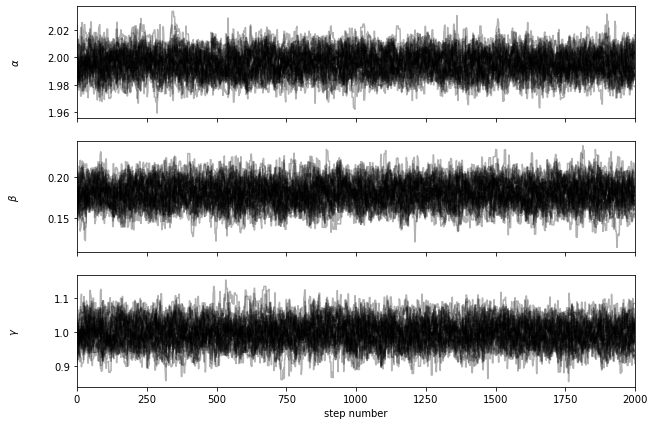

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\\alpha$", "$\\beta$", "$\\gamma$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the
maximum likelihood values and then they quickly wander and start exploring the
full posterior distribution.
In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in".
That is a hard statement to make quantitatively, but we can look at an estimate
of the integrated autocorrelation time (see the :ref:`autocorr` tutorial for more details):

In [16]:
tau = sampler.get_autocorr_time()
print(tau)

[32.44795751 34.223676   32.08285197]


This suggests that only about 40 steps are needed for the chain to "forget" where it started.
It's not unreasonable to throw away a few times this number of steps as "burn-in".
Let's discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [17]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(4032, 3)


In [18]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.647


## Results

Now that we have this list of samples, let's make one of the most useful plots
you can make with your MCMC results: *a corner plot*.
You'll need the [corner.py module](http://corner.readthedocs.io) but
once you have it, generating a corner plot is as simple as:

<class 'numpy.ndarray'>


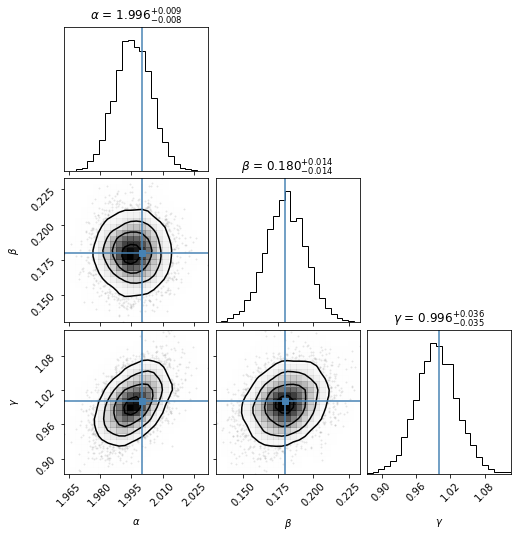

In [19]:
import corner

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

fig = corner.corner(
    flat_samples, bins=25, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");
#);

print(type(flat_samples))

In [20]:
g = flat_samples[:, 2]

def gaussian(x, mean, amplitude, s0):
    return amplitude * np.exp( - (x - mean)**2 /2./s0**2)

gamma: 0.995792326064229 \pm 0.0006706631358015035
sigma: 0.03547876386465148 \pm 0.0006707222983786373


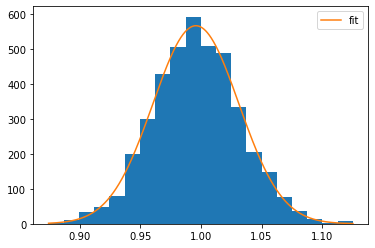

In [21]:
bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
print('gamma:',popt[0],'\pm',perr[0])
print('sigma:',popt[2],'\pm',perr[2])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()

In [22]:
from IPython.display import display, Math


labels_2 = ["\\alpha", "\\beta", "\\gamma"]
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml2))
print("beta = {0:.3f}".format(beta_ml2))
#print("delta = {0:.3f}".format(delta_ml))
print("gamma = {0:.3f}".format(gamma_ml2))

Maximum likelihood estimates:
alpha = 1.996
beta = 0.180
gamma = 0.995


Sobre el paper de Schwab. Se puede ver que hay ciertos typos no demasiado graves pero sí bastante recurrentes.
Por lo que la mejor idea antes de comenzar a trabajar con ese paper es volver a hacer todas las cuentas de nuevo.